# Metodi iterativi

- Volpato Mattia 866316
- Andreotti Stefano 851596

Notebook per la risoluzione di un sistema lineare dato da una matrice sparsa simmetrica e definita positiva

## Importazione librerie

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

from matspy import spy

import time

## Caricamento matrice e parametri

In [16]:
# Inserisci qui il percorso della matrice
MATRIX_PATH = './matrici/spa1.mtx'

# Valori da inserire nel vettore soluzione iniziale ('zeros' or 'random')
MODE = 'zeros'

# Parametri metodo di risoluzione
METHOD = 'jacobi'
MAX_ITER = 20000
EPSILON = 1e-9

# Parametri test
N_TEST = 3
CHECK_CORRECTNESS = True
VERBOSE = True

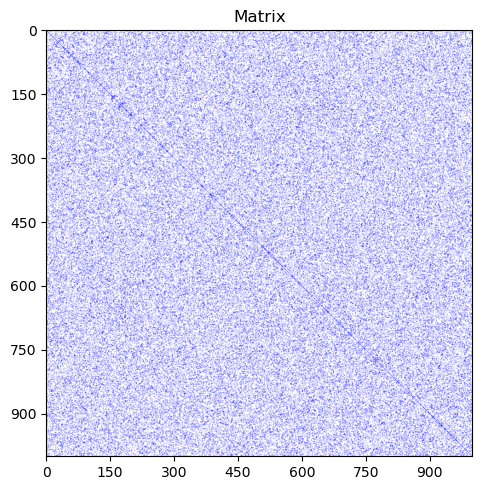

Non-zero entries: 182264, 18.23%


In [4]:
A = sp.io.mmread(MATRIX_PATH).tocsr()
spy(A, title='Matrix', figsize=5, dpi=300)
print(f"Non-zero entries: {A.count_nonzero()}, {A.count_nonzero() / (A.shape[0] * A.shape[1]) * 100:.2f}%")

## Creazione del termine noto *b* e della soluzione iniziale $x_0$

In [5]:
def create_b(A:sp.sparse.csr_matrix, x:np.ndarray=None) -> np.ndarray:
    if x is None:
        x = np.ones(A.shape[1], dtype=np.float64)
        
    return A.dot(x)

In [6]:
def initialize_x_0(N:int, mode:str='zeros', L:float=-1, U:float=1) -> np.ndarray:
    if mode == 'random':
        return np.random.uniform(L, U, N)

    return np.zeros(N, dtype=np.float64)

In [7]:
b = create_b(A)
x_0 = initialize_x_0(A.shape[0], mode=MODE)

assert len(b) == A.shape[0] == A.shape[0] == len(x_0), "Shapes mismatch"

b.shape, x_0.shape

((1000,), (1000,))

## Condizione di terminazione

In [8]:
def check_termination(r:np.array, b:np.ndarray, epsilon:float) -> bool:
    return np.linalg.norm(r) / np.linalg.norm(b) < epsilon

## Funzione metodi iterativi

In [9]:
def solve(check_termination:callable, update_x:callable, 
          A:sp.sparse.csr_matrix, b:np.ndarray, x_0:np.ndarray, 
          max_iter:int, epsilon:float, support:any=None) -> tuple[np.ndarray, int]:
    
    x = x_0.copy()
    k = 0
    r = b - A.dot(x)

    while not check_termination(r, b, epsilon):
        x, r, support = update_x(A, b, x, support)
        k += 1
        
        if k > max_iter:
            break

    return x, k

## Funzione di testing

In [20]:
def test(solver:callable, epsilon:float, max_iter:int, n_test:int=1, check_correctness:bool=True, verbose:bool=False):
    matrixes_times = {}

    if verbose:
        print(f"Testing matrix A")

    matrixes_times['A'] = {}
    failed, reason = False, None

    for j in range(n_test):
        if verbose:
            print(f"\tTest {j + 1}/{n_test}: ", end="")

        start = time.time()
        solution, iterations = solver(A, b, x_0, epsilon, max_iter)
        end = time.time()

        times = end - start

        if iterations > max_iter:
            failed = True
            reason = "MAX_ITER_FAIL"
            if verbose:
                print("Failed for max iterations=", iterations)
            break

        if check_correctness:
            if not np.allclose(A.dot(solution), b, atol=epsilon + epsilon * 1/2):
                failed = True
                reason = "CORRECTNESS_FAIL"
                if verbose:
                    print("Failed for correctness")
                    print(f"x: {solution}")
                break
        
        if verbose:
            print(f"Passed with {iterations} iterations in {times} s")

    if not failed:
        matrixes_times['A']['time'] = times
        matrixes_times['A']['iter'] = iterations
    else:
        matrixes_times['A'] = reason

    return matrixes_times

## Definizione dei metodi

### Jacobi

In [11]:
def jacobi_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray, 
                  P_inv:sp.sparse.csr_matrix) -> tuple[np.array, np.array, sp.sparse.csr_matrix]:
    
    r = b - A.dot(x)
    x = x + P_inv.dot(r)

    return x, r, P_inv

### Gauss-Seidel

In [12]:
from scipy.linalg import solve_triangular

forward_substitution_scipy = lambda L, b: solve_triangular(L.toarray(), b, lower=True)

def forward_substitution_naive(L:sp.sparse.csr_matrix, b:np.array) -> np.array:
    n = L.shape[0]
    x = np.zeros(n, dtype=np.float64)

    if not np.all(L.diagonal()):
        raise ValueError("Matrix L has zeros on the diagonal: forward substitution not applicable.")

    x[0] = b[0] / L[0, 0]
    
    for i in range(1, n):
        x[i] = (b[i] - L[i, :i].toarray().flatten().dot(x[:i])) / L[i, i]  

    return x

def gauss_seidel_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray,
                        P:sp.sparse.csr_matrix) -> tuple[np.array, np.array, sp.sparse.csr_matrix]:
    
    r = b - A.dot(x)
    y = forward_substitution_scipy(P, r)
    x = x + y

    return x, r, P

### Discesa del gradiente

In [13]:
def gradient_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray, _:any) -> tuple[np.array, np.array, any]:
    r = b - A * x
    y = A * r

    a = r @ r           # Dot product
    c = r @ y           # Dot product
    x = x + a / c * r

    return x, r, _

### Discesa del gradiente coniugato

In [14]:
def conjugate_gradient_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray,
                              d:np.array) -> tuple[np.array, np.array, np.array]:
    r = b - A * x
    y = A * d 

    alpha = (d @ r) / (d @ y)
    x = x + alpha * d

    r = b - A * x
    w = A * r
    beta = (d @ w) / (d @ y)
    d = r - beta * d
    
    return x, r, d

## Risoluzione

In [17]:
if METHOD == 'jacobi':
    solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, jacobi_update, A, b, x_0, max_iter, epsilon, sp.sparse.diags(1 / A.diagonal(), format='csr'))
elif METHOD == 'gauss-seidel':
    solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, gauss_seidel_update, A, b, x_0, max_iter, epsilon, sp.sparse.tril(A, format='csr'))
elif METHOD == 'gradiente':
    solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, gradient_update, A, b, x_0, max_iter, epsilon)
elif METHOD == 'gradiente coniugato':
    solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, conjugate_gradient_update, A, b, x_0, max_iter, epsilon, b - A * x_0)
else:
    print(f"Metodo {METHOD} non valido")

In [18]:
solution, iterations = solver(A, b, x_0, EPSILON, MAX_ITER)
solution

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.00000001, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.00000002, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.00000003, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.00000001,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [21]:
test(solver, epsilon=EPSILON, max_iter=MAX_ITER, n_test=N_TEST, check_correctness=CHECK_CORRECTNESS, verbose=VERBOSE)

Testing matrix A
	Test 1/3: Passed with 281 iterations in 0.13368916511535645 s
	Test 2/3: Passed with 281 iterations in 0.10806059837341309 s
	Test 3/3: Passed with 281 iterations in 0.07808470726013184 s


{'A': {'time': 0.07808470726013184, 'iter': 281}}

## Grafici e risultati

In [23]:
epsilons = [1e-3, 1e-6, 1e-9, 1e-12]
max_iters = [MAX_ITER, MAX_ITER, MAX_ITER, MAX_ITER]
n_tests = [3, 3, 3, 3]
check_correctnesses = [False, False, False, False]
verboses = [False, False, False, False]

epsilon_df = pd.DataFrame(zip(epsilons, max_iters, n_tests), columns=['epsilon', 'max_iter', 'n_test'])

epsilon_df['A_time'] = None
epsilon_df['A_iter'] = None

for i in range(len(epsilons)):
    result_dict = test(solver, epsilon=epsilons[i], max_iter=max_iters[i], n_test=n_tests[i], 
                                      check_correctness=check_correctnesses[i], verbose=verboses[i])

    for j in enumerate(result_dict):
        epsilon_df.loc[i, 'A_time'] = result_dict['A']['time']
        epsilon_df.loc[i, 'A_iter'] = result_dict['A']['iter']

epsilon_df

,epsilon,max_iter,n_test,A_time,A_iter
0,1.000000e-03,20000,3,0.058815,83
1,1.000000e-06,20000,3,0.09418,182
2,1.000000e-09,20000,3,0.141629,281
3,1.000000e-12,20000,3,0.146414,381


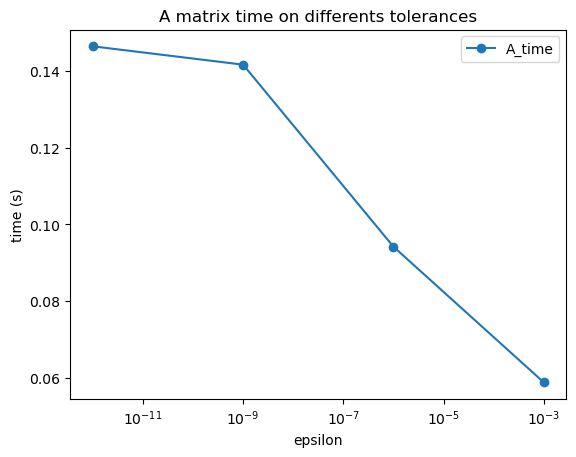

In [24]:
epsilon_df[['epsilon', 'A_time']].plot(x='epsilon', kind='line', ylabel='time (s)', 
                                                                logx=True, marker='o', 
                                                                title='A matrix time on differents tolerances')

plt.show()

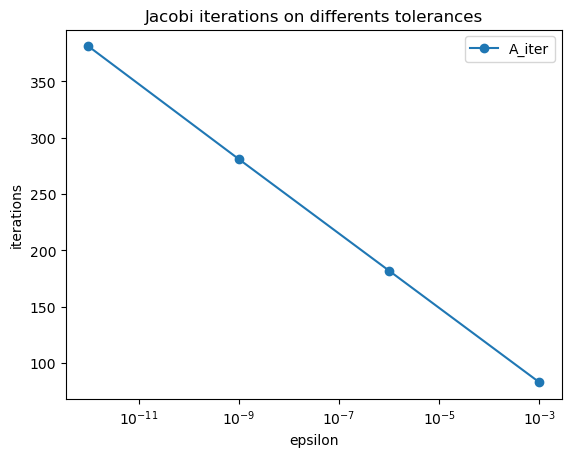

In [25]:
epsilon_df[['epsilon', 'A_iter', ]].plot(x='epsilon', kind='line', ylabel='iterations', 
                                                                logx=True, marker='o', 
                                                                title='Jacobi iterations on differents tolerances')
plt.show()